In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score
import pickle, os, warnings
warnings.filterwarnings("ignore")

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [ ]:

DATA_PATH = "Telco-Customer-Churn.csv"
os.path.exists(DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Dataset loaded from local file:", df.shape)

df.head()


Dataset loaded from local file: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1. Data Preparation & Cleaning

In [17]:

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.fillna(df.median(numeric_only=True), inplace=True)
df.drop_duplicates(inplace=True)

target = "Churn"
X = df.drop(columns=["customerID", target], errors="ignore")
y = df[target].map({"Yes":1, "No":0})

print("Data cleaned successfully. Shape:", X.shape)


Data cleaned successfully. Shape: (7043, 19)


## 2. Exploratory Data Analysis

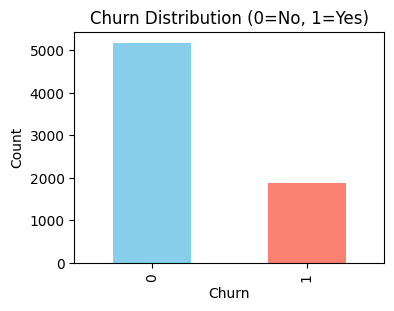

In [18]:

plt.figure(figsize=(4,3))
y.value_counts().plot(kind="bar", color=["skyblue","salmon"])
plt.title("Churn Distribution (0=No, 1=Yes)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()


## 3. Train-Test Split & Preprocessing

In [19]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ("num", StandardScaler(), numeric_features)
])

print("Categorical:", len(categorical_features), "| Numeric:", len(numeric_features))


Categorical: 15 | Numeric: 4


## 4. Model 1 — CHAID-like (Decision Tree using Entropy)

In [20]:

tree_clf = Pipeline([("prep", preprocessor), 
                     ("model", DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42))])
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
y_proba_tree = tree_clf.predict_proba(X_test)[:,1]

acc_tree = accuracy_score(y_test, y_pred_tree)
auc_tree = roc_auc_score(y_test, y_proba_tree)

print(f"Decision Tree → Accuracy: {acc_tree:.3f}, ROC-AUC: {auc_tree:.3f}")


Decision Tree → Accuracy: 0.797, ROC-AUC: 0.831


## 5. Model 2 — Logistic Regression

In [21]:

logit_clf = Pipeline([("prep", preprocessor), ("model", LogisticRegression(max_iter=1000))])
logit_clf.fit(X_train, y_train)
y_pred_log = logit_clf.predict(X_test)
y_proba_log = logit_clf.predict_proba(X_test)[:,1]

acc_log = accuracy_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_proba_log)

print(f"Logistic Regression → Accuracy: {acc_log:.3f}, ROC-AUC: {auc_log:.3f}")


Logistic Regression → Accuracy: 0.806, ROC-AUC: 0.842


## 6. Evaluation — ROC Curve

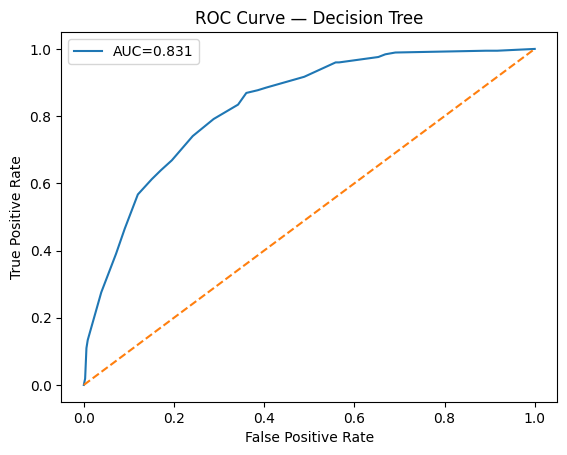

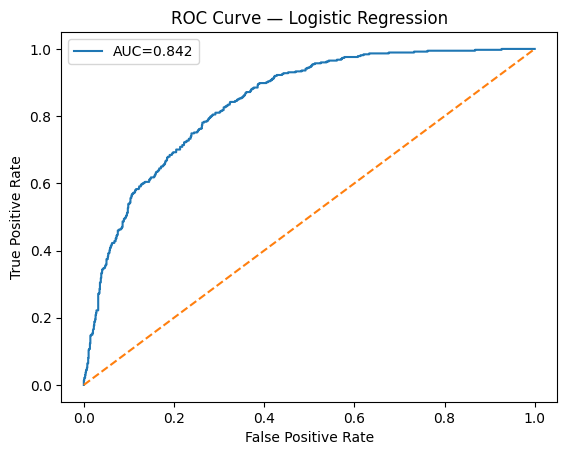

In [22]:

from sklearn.metrics import roc_curve

def plot_roc(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, y_score):.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

plot_roc(y_test, y_proba_tree, "ROC Curve — Decision Tree")
plot_roc(y_test, y_proba_log, "ROC Curve — Logistic Regression")


## 7. Model Comparison

In [23]:

comparison = pd.DataFrame({
    "Model": ["Decision Tree", "Logistic Regression"],
    "Accuracy": [acc_tree, acc_log],
    "ROC_AUC": [auc_tree, auc_log]
})
comparison


,Model,Accuracy,ROC_AUC
0,Decision Tree,0.797019,0.831234
1,Logistic Regression,0.805536,0.841874


## 8. Model Deployment (Pickle)

In [24]:

os.makedirs("models", exist_ok=True)
with open("models/tree_model.pkl","wb") as f:
    pickle.dump(tree_clf, f)
with open("models/logit_model.pkl","wb") as f:
    pickle.dump(logit_clf, f)

print("✅ Models saved successfully in /models/")


✅ Models saved successfully in /models/
